### Tech Challenge Fase 1

O objetivo é o desenvolvimento de um **modelo preditivo de regressão** para estimar os **custos de planos de saúde individuais**.

Os dados utilizados para a análise possuem as seguintes informações:

- Idade
- Gênero
- IMC
- Número de filhos
- Se a pessoa é fumante
- Região onde reside

O processo de desenvolvimento do modelo passará pelas fases de:

1) Preparação do ambiente

2) Exploração de Dados

3) Pré-processamento de Dados

4) Treinamento e Avaliação

#### 1) Preparação do ambiente

Nessa fase iremos fazer a importação das bibliotecas e leitura dos dados que serão utilizados para a análise.

In [ ]:
!pip install plotly_express

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2) Exploração dos Dados

Para entender a estrutura, os padrões do dataset e possíveis problemas no dataset, serão feitas algumas análises que envolve:

2.1) Estatísticas descritivas

2.2) Distribuição das variáveis

2.3) Análise de correlação

2.4) Análise bivariada

#### 2.1) Estatísticas descritivas

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Com base no resumo apresentado acima, podemos identificar as seguintes informações:

**Valores de Cobrança:**

- O valor máximo cobrado de um paciente é de R$ 63.770,43.
- O valor mínimo cobrado de um paciente é de R$ 1.121,87.

**Faixa Etária:**

- A faixa etária dos pacientes está compreendida entre 18 e 64 anos.

**Número de Filhos:**

- O número de filhos por paciente varia de 0 a 5.

**Índice de Massa Corporal (IMC):**

- O IMC máximo registrado é de 53.
- O IMC mínimo registrado é de 15.

#### 2.2) Distribuição das variáveis

In [ ]:
df["sex"].value_counts()

,count
sex,
male,676
female,662


In [ ]:
df["smoker"].value_counts()

,count
smoker,
no,1064
yes,274


In [ ]:
# # Substituindo os valores da coluna region
# _replace = {
#     "southeast": "Sudeste",
#     "southwest": "Sudoeste",
#     "northwest": "Noroeste",
#     "northeast": "Nordeste"
# }
# df["region"] = df["region"].replace(_replace)

In [ ]:
df["region"].value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [ ]:
df["children"].value_counts()

,count
children,
0,574
1,324
2,240
3,157
4,25
5,18


In [ ]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


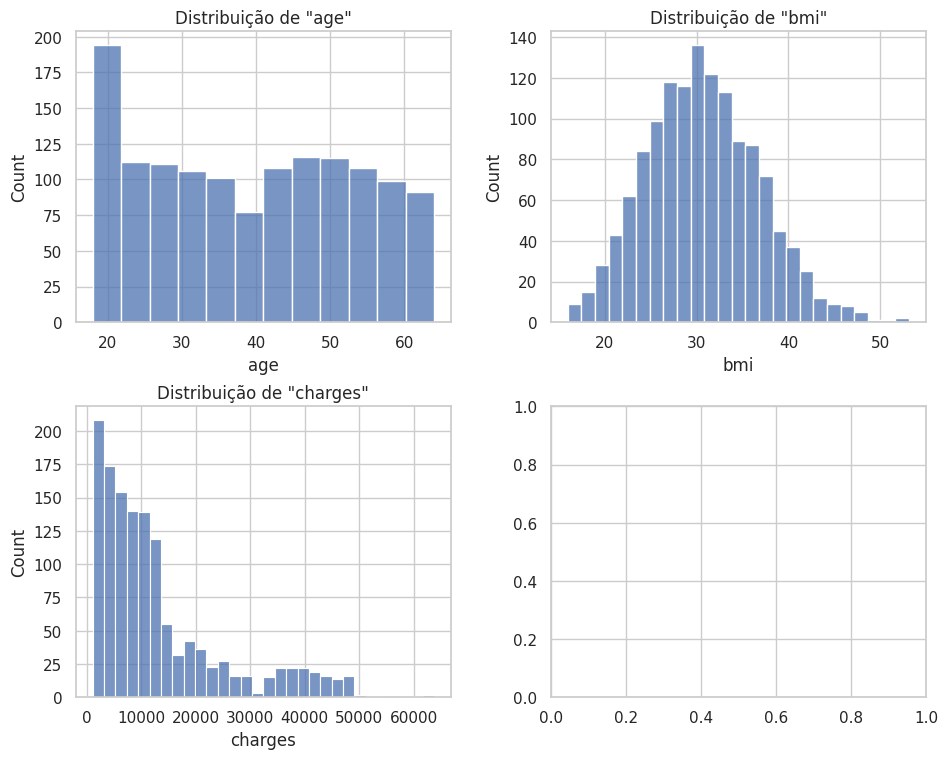

In [ ]:
# Lista de variáveis numéricas
numerical_columns = ['age', 'bmi', 'charges']

# Configuração do grid para as subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # grade 2x2
fig.tight_layout(pad=3.0)

# Gera os histogramas para cada variável
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Distribuição de "{col}"')

plt.show()

#### 2.3 Análise de correlação

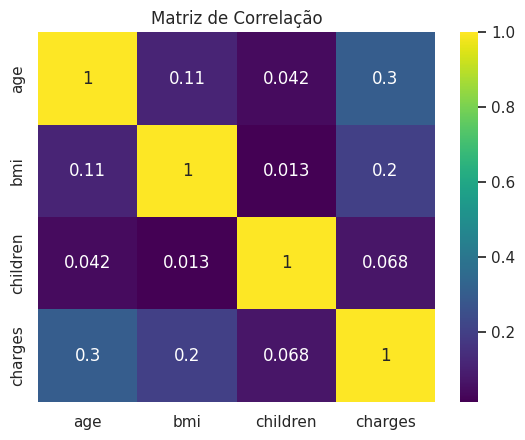

In [ ]:
# Seleciona apenas as colunas numéricas para o cálculo da correlação
numerical_df = df.select_dtypes(include=['number'])

# Criação da matriz de correlação entre as variáveis numéricas
sns.heatmap(numerical_df.corr(), annot=True, cmap="viridis")
plt.title('Matriz de Correlação')
plt.show()

De acordo com o resultado obtido com a matriz de correlação das variáveis numéricas, podemos concluir que:


- A correlação entre **custos e IMC é positiva, mas relativamente baixa**, com um coeficiente em torno de 0.2.
- A correlação entre **custos e idade é positiva e moderada**, com um coeficiente em torno de 0.3.
- A correlação entre **custos e número de filhos é muito baixa**, com um coeficiente de apenas 0.068.

**Conclusão:**

A matriz de correlação sugere que **idade e IMC são mais relevantes para prever custos**, enquanto **número de filhos** pode ter uma **menor prioridade na modelagem** preditiva.


#### 2.4 Análise bivariada

In [ ]:
import plotly_express as px

px.violin(df,y="charges",x="region",color="smoker",box=True,points="all")

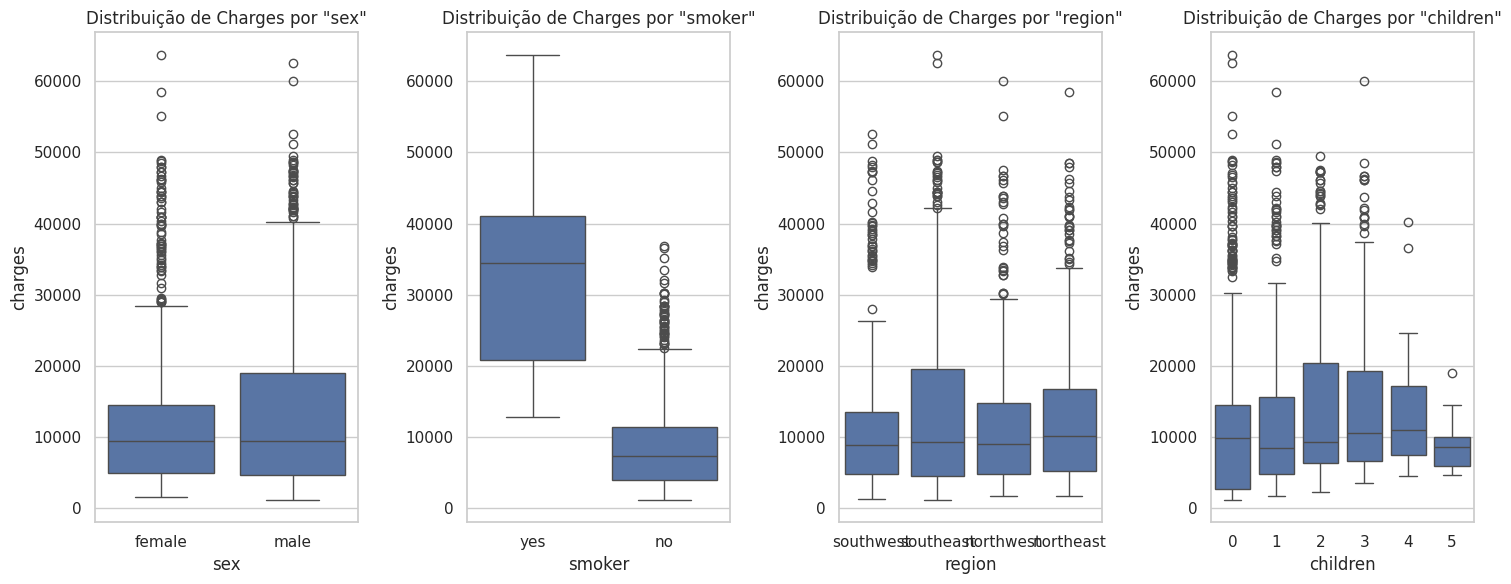

In [ ]:
# Configura o tamanho da figura
plt.figure(figsize=(15, 6))

# Cria um subplot para cada variável categórica em relação a charges
# Boxplot para 'sex'
plt.subplot(1, 4, 1)
sns.boxplot(data=df, x='sex', y='charges')
plt.title('Distribuição de Charges por "sex"')

# Boxplot para 'smoker'
plt.subplot(1, 4, 2)
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('Distribuição de Charges por "smoker"')

# Boxplot para 'region'
plt.subplot(1, 4, 3)
sns.boxplot(data=df, x='region', y='charges')
plt.title('Distribuição de Charges por "region"')

# Boxplot para 'children'
plt.subplot(1, 4, 4)
sns.boxplot(data=df, x='children', y='charges')
plt.title('Distribuição de Charges por "children"')
plt.tight_layout()

plt.show()

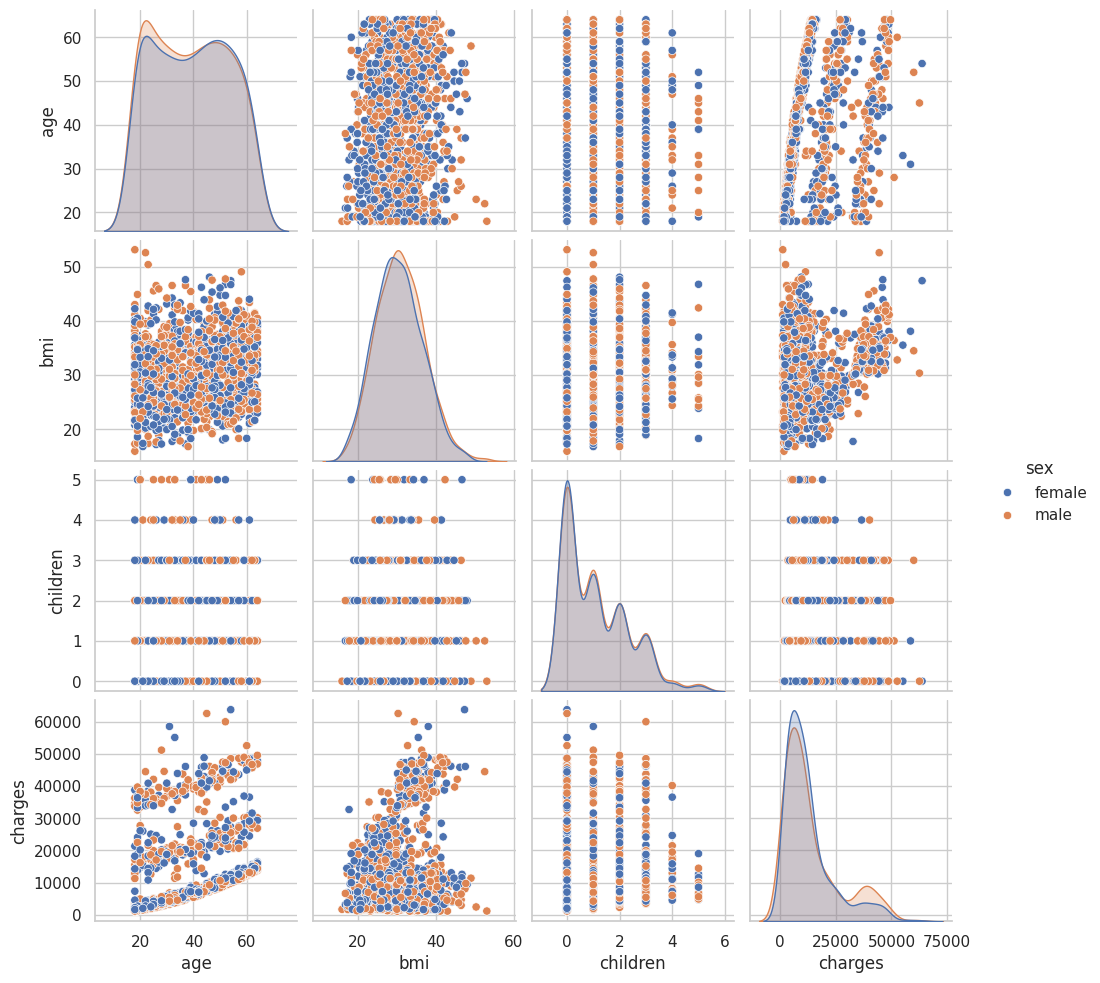

In [ ]:
# Pair plot das variáveis numéricas
sns.pairplot(df, vars=['age', 'bmi', 'children', 'charges'], hue='sex')
plt.show()

Com base nos boxplots fornecidos, podemos obter alguns insights sobre a relação entre **charges** (custos de planos de saúde) e as **variáveis categóricas** (sex, smoker, region):

**smoker (fumante):**

- Há uma **diferença clara nos custos** para pessoas **fumantes** em comparação com **não fumantes**.
- Os **fumantes tendem** a ter **custos médios muito mais altos**, com uma **mediana** de charges significativamente **superior à dos não fumantes**.
- A **variabilidade** dos custos entre **fumantes** também é **maior**, indicando que ser fumante é um **fator importante no aumento dos custos** dos planos de saúde.

**sex (gênero):**

- Há uma **pequena diferença** nos custos de planos de saúde **entre homens e mulheres**, com os **homens tendendo** a ter custos um pouco **mais altos em média**.
- Importante ressaltar que **essa diferença é bem menor em comparação** com o impacto observado em relação à variável fumante.


**region (região):**

- As diferenças nos custos de planos de saúde entre as regiões são visíveis, mas menos pronunciadas em comparação com o status de fumante.
A região sudeste (southeast) parece ter uma mediana de charges um pouco mais alta do que as outras regiões, enquanto o sudoeste (southwest) apresenta a mediana mais baixa.

- A **região Sudeste** (southeast) **tem uma mediana** de custos um pouco **mais alta** do que as **outras regiões**.
- A **região Sudoeste** (southwest) apresenta a **mediana** de custos **mais baixa**.
- Vale destacar que a **variabilidade** dos custos é **semelhante entre as regiões**, o que indica que a **localização pode ter um efeito moderado** sobre os custos, mas é menos relevante do que a variável fumante.


##### Conclusão
A variável **fumante (smoker) é o fator categórico mais impactante nos custos** dos planos de saúde, seguido pela região e pelo gênero.


#### 3) Pré-processamento dos dados

Nessa etapa, o objetivo é preparar os dados para realização da análise e serão realizadas as seguintes transformações:

- Codificação das variáveis categóricas utilizando label encoding e one-hot encoding
- Separação da variável dependente da variável independente.
- Normalização dos dados através das técnicas:
    - Min Max Scaler
    - Standard Scaler

Diferentes técnicas para os datasets:
- Sem scaler
- Min Max Scaler
- Standard Scaler

Técnicas:
- Linear Regression;
- KNN Regressor;
- Decision Tree Regressor;
- Random Forest Regressor;

Variáveis independentes:
- age
- bmi
- smoker


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

df_coded = df.copy()
df_coded['sex'] = label_encoder.fit_transform(df_coded['sex'])
df_coded['smoker'] = label_encoder.fit_transform(df_coded['smoker'])

dummy_region = pd.get_dummies(df_coded['region'], prefix='dummy')
df_coded = pd.concat([df_coded, dummy_region], axis=1)
df_coded.drop("region", axis=1, inplace=True)

df_coded.head()

,age,sex,bmi,children,smoker,charges,dummy_northeast,dummy_northwest,dummy_southeast,dummy_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


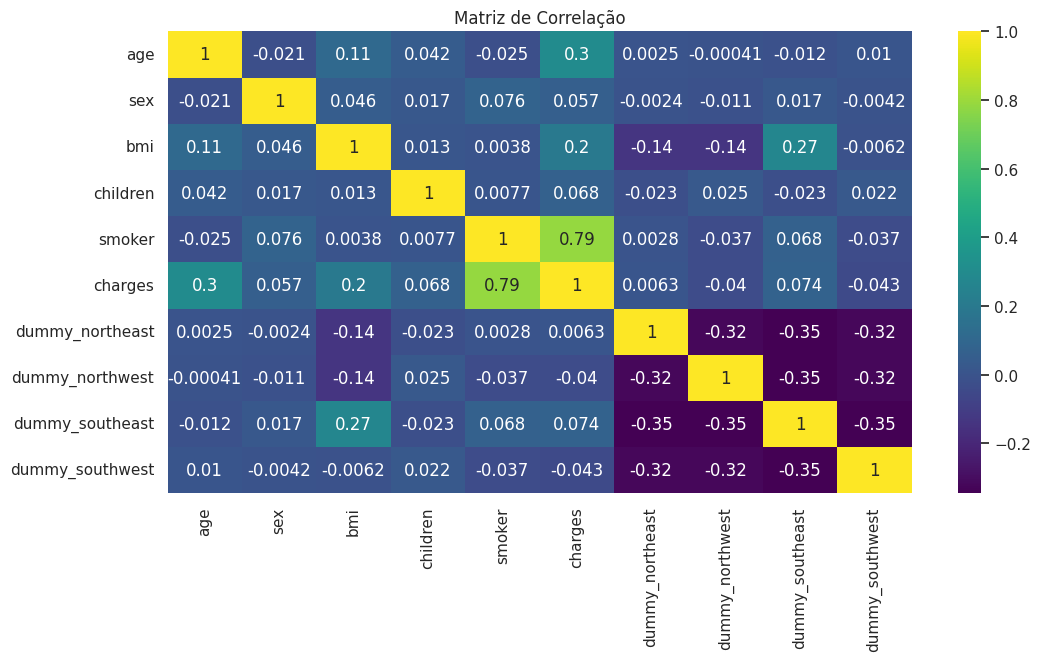

In [ ]:
# Criação da matriz de correlação entre as variáveis numéricas
plt.figure(figsize=(12, 6))
sns.heatmap(df_coded.corr(), annot=True, cmap="viridis")
plt.title('Matriz de Correlação')
plt.show()


Já foi observado que as variáveis IMC e idade possuem correlação (mesmo que não muito significativa) em relação ao custo. Em relação às demais variáveis pode-se observar o seguinte resultado:

- **Ser fumante**: A **correlação é muito forte** e negativa entre não fumantes e custos (-0,79) e positiva entre fumantes e charges (0,79). Isso **indica que fumar está fortemente associado a custos médicos mais altos**.

- **Regiões**: As **correlações entre as regiões e charges são fracas**, mas a região **sudeste** apresenta a **maior correlação positiva** com charges (0,07), sugerindo um **leve aumento de custos** nessa região.

- **Sexo**: **Não há correlações significativas** entre o sexo e os custos, o que sugere que a **influência do gênero nos custos médicos é mínima** em comparação com outras variáveis.


In [ ]:
def split_datasets(df, variaveis_independentes, variavel_dependente, scaler, test_size=0.2, random_state=42):
    # Seleciona as variáveis independentes e a dependente
    X = df[variaveis_independentes]
    y = df[variavel_dependente]

    if scaler:
        # Aplica o scaler nos dados
        X = scaler.fit_transform(X)

    # Separa o dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
# Printa na tela o padrao de scaler sendo analisado
def print_scaler(scaler):
  print("-----------------------------------------------------")
  print(f"- Avaliando modelos lineares usando  {scaler}-")
  print("-----------------------------------------------------")

In [ ]:
def evaluate_models(models, df, variaveis_independentes, variavel_dependente, scaler):
  print_scaler(scaler)
  results = []
  for name, model in models:
    # Registra o tempo de início
    begin = time.time()

    X_train, X_test, y_train, y_test = split_datasets(df, variaveis_independentes, variavel_dependente, scaler)

    # Fit the classifier on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # 5. Avaliar o desempenho do modelo usando MAE, MSE, RMSE e R²
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)

    # Calcula o tempo de execução
    duration = time.time() - begin

    # Print the accuracy for each classifier
    print(f'{name}: MAE = {mae:.3f} - MSE = {mse:.3f} - RMSE = {rmse:.3f} - R2 = {r2:.3f} [{duration:.3f}sec]')

    result = {
        'Scaler': scaler,
        'Modelo': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'Duração': duration
    }
    results.append(result)
  return  results

In [ ]:
variaveis_independentes = ['age', 'bmi', 'smoker']


In [ ]:
# Configurando modelos
regressors = [
     ('SVR                    ', SVR(kernel='linear', C=4000.0))
    ,('Decision Tree Regressor', DecisionTreeRegressor(max_depth=33))
    # ,('MLP Regressor          ', MLPRegressor(hidden_layer_sizes=(1000,), max_iter=2000))
    ,('Ridge                  ', Ridge(alpha=1.0))
    ,('Elastic Net            ', ElasticNet(alpha=0.01, l1_ratio=0.5))
    ,('Linear Regression      ', LinearRegression())
    ,('Lasso                  ', Lasso(alpha=0.1))
    ,('Random Forest Regressor', RandomForestRegressor(n_estimators=30, random_state=42))
]

In [ ]:
results_standard = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=StandardScaler())
results_minmax = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=MinMaxScaler())
results = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=None)

-----------------------------------------------------
- Avaliando modelos lineares usando  StandardScaler()-
-----------------------------------------------------
SVR                    : MAE = 3308.206 - MSE = 43804691.573 - RMSE = 6618.511 - R2 = 0.718 [0.211sec]
Decision Tree Regressor: MAE = 3091.159 - MSE = 38808872.700 - RMSE = 6229.677 - R2 = 0.750 [0.018sec]
Ridge                  : MAE = 4261.978 - MSE = 34517967.935 - RMSE = 5875.199 - R2 = 0.778 [0.018sec]
Elastic Net            : MAE = 4268.118 - MSE = 34542561.148 - RMSE = 5877.292 - R2 = 0.778 [0.013sec]
Linear Regression      : MAE = 4260.560 - MSE = 34512843.880 - RMSE = 5874.763 - R2 = 0.778 [0.013sec]
Lasso                  : MAE = 4260.553 - MSE = 34512883.490 - RMSE = 5874.767 - R2 = 0.778 [0.011sec]
Random Forest Regressor: MAE = 2811.365 - MSE = 26651682.167 - RMSE = 5162.527 - R2 = 0.828 [0.165sec]
-----------------------------------------------------
- Avaliando modelos lineares usando  MinMaxScaler()-
---------

In [ ]:
df_results = [
    pd.DataFrame(results_standard),
    pd.DataFrame(results_minmax),
    pd.DataFrame(results)]

StandardScaler()


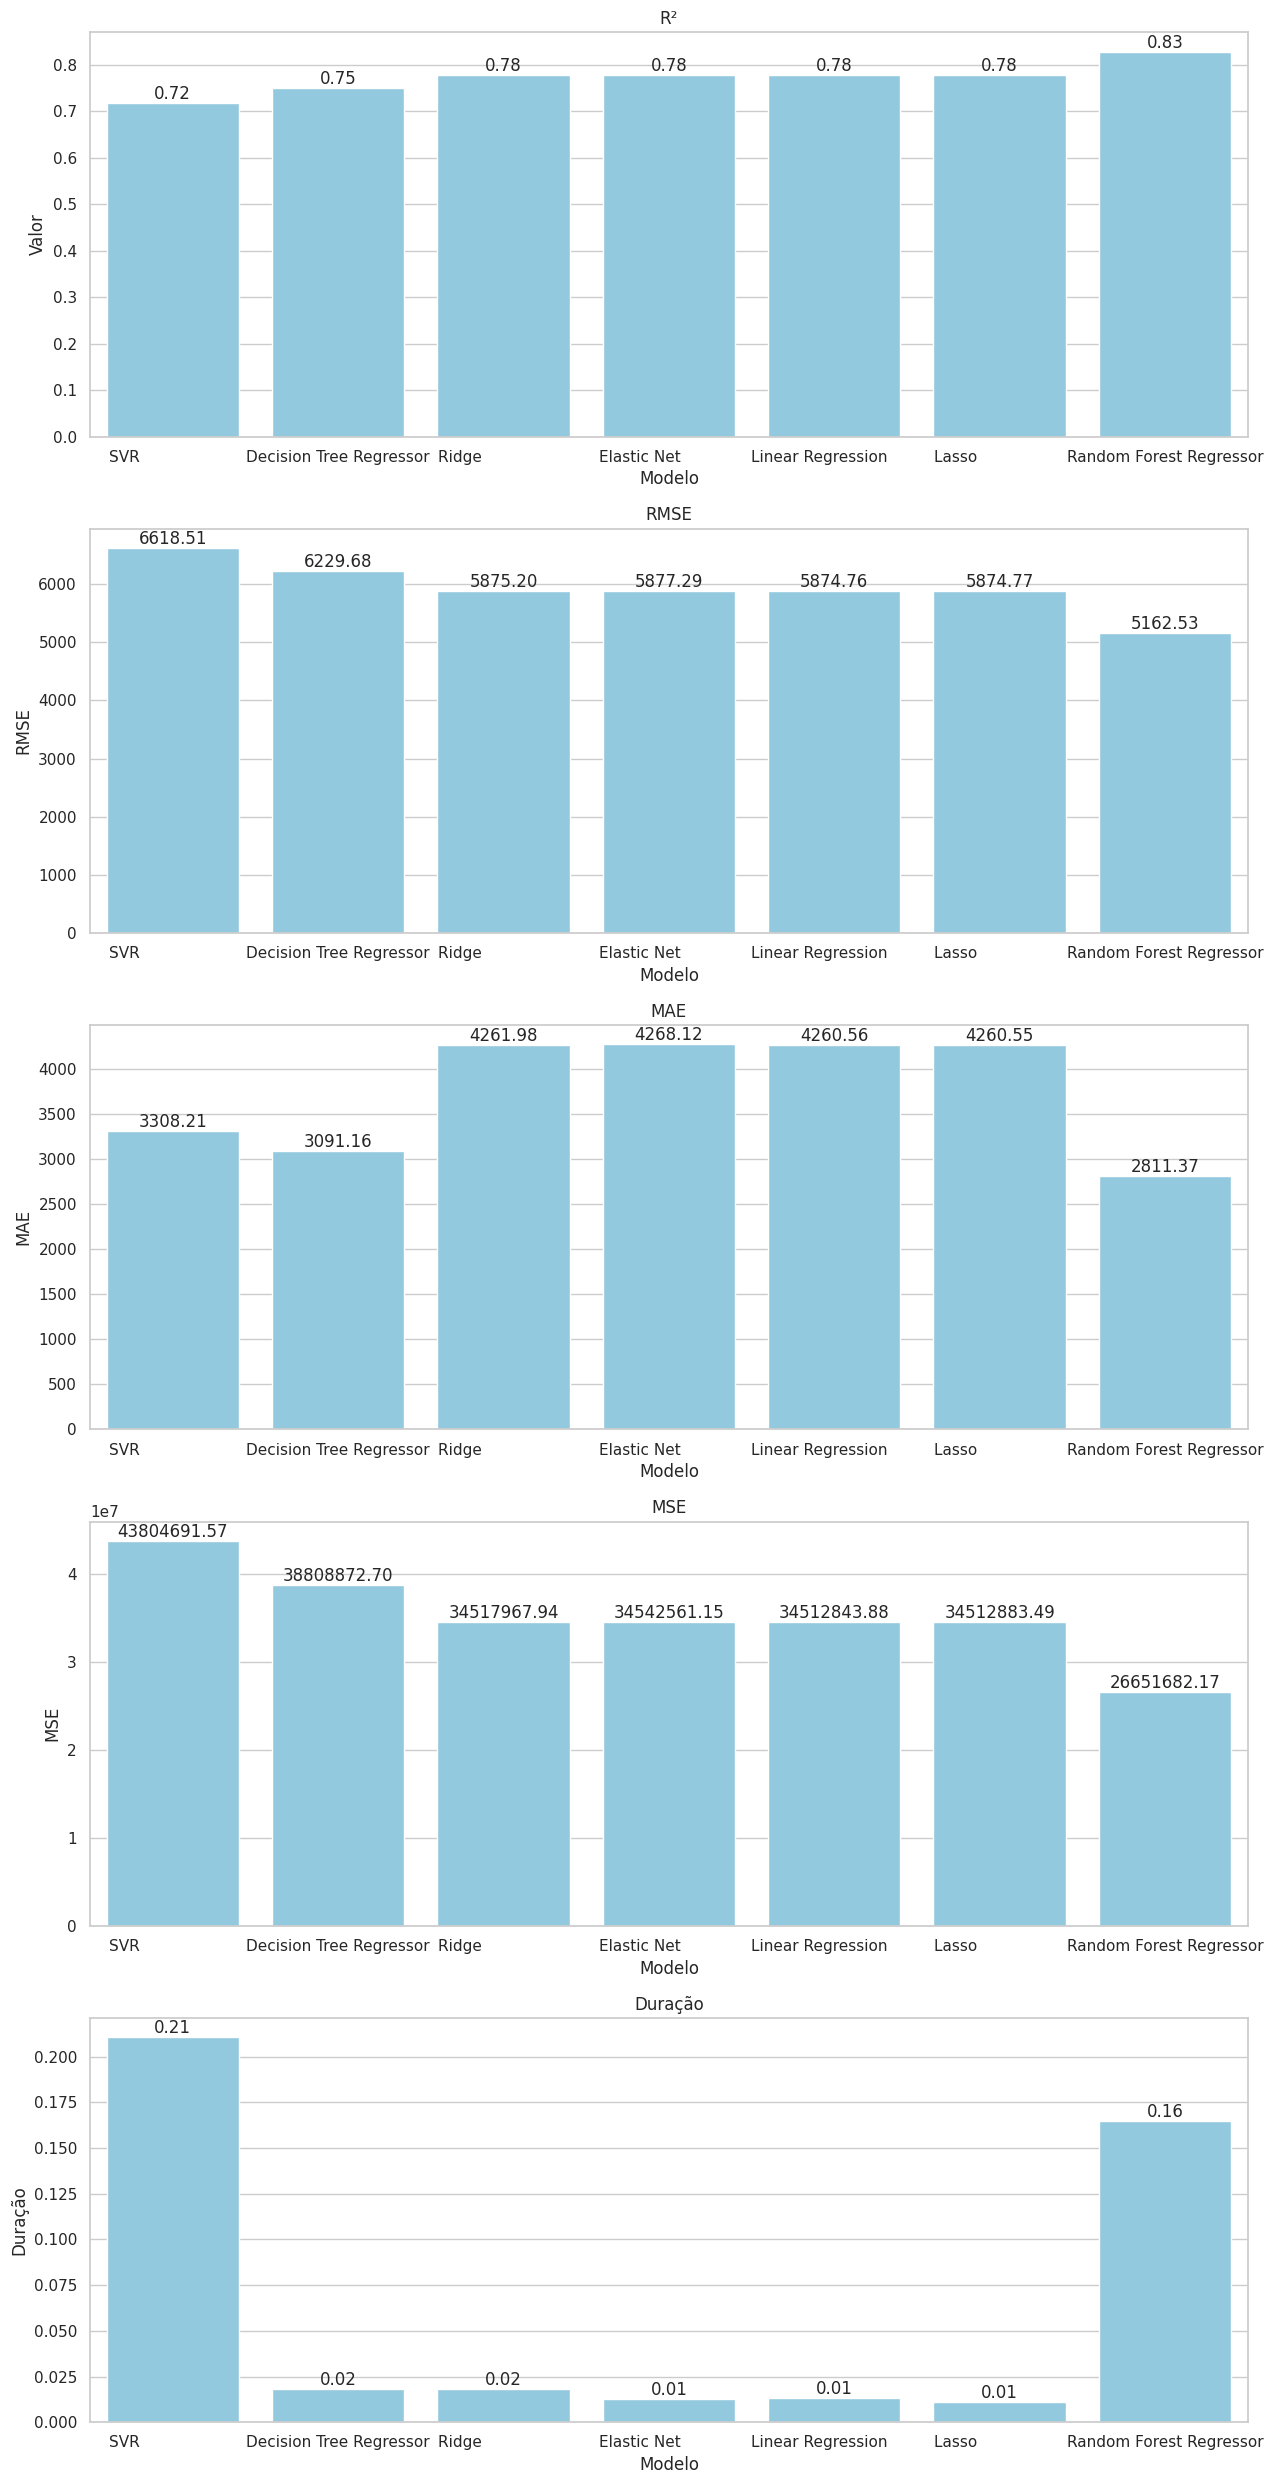

MinMaxScaler()


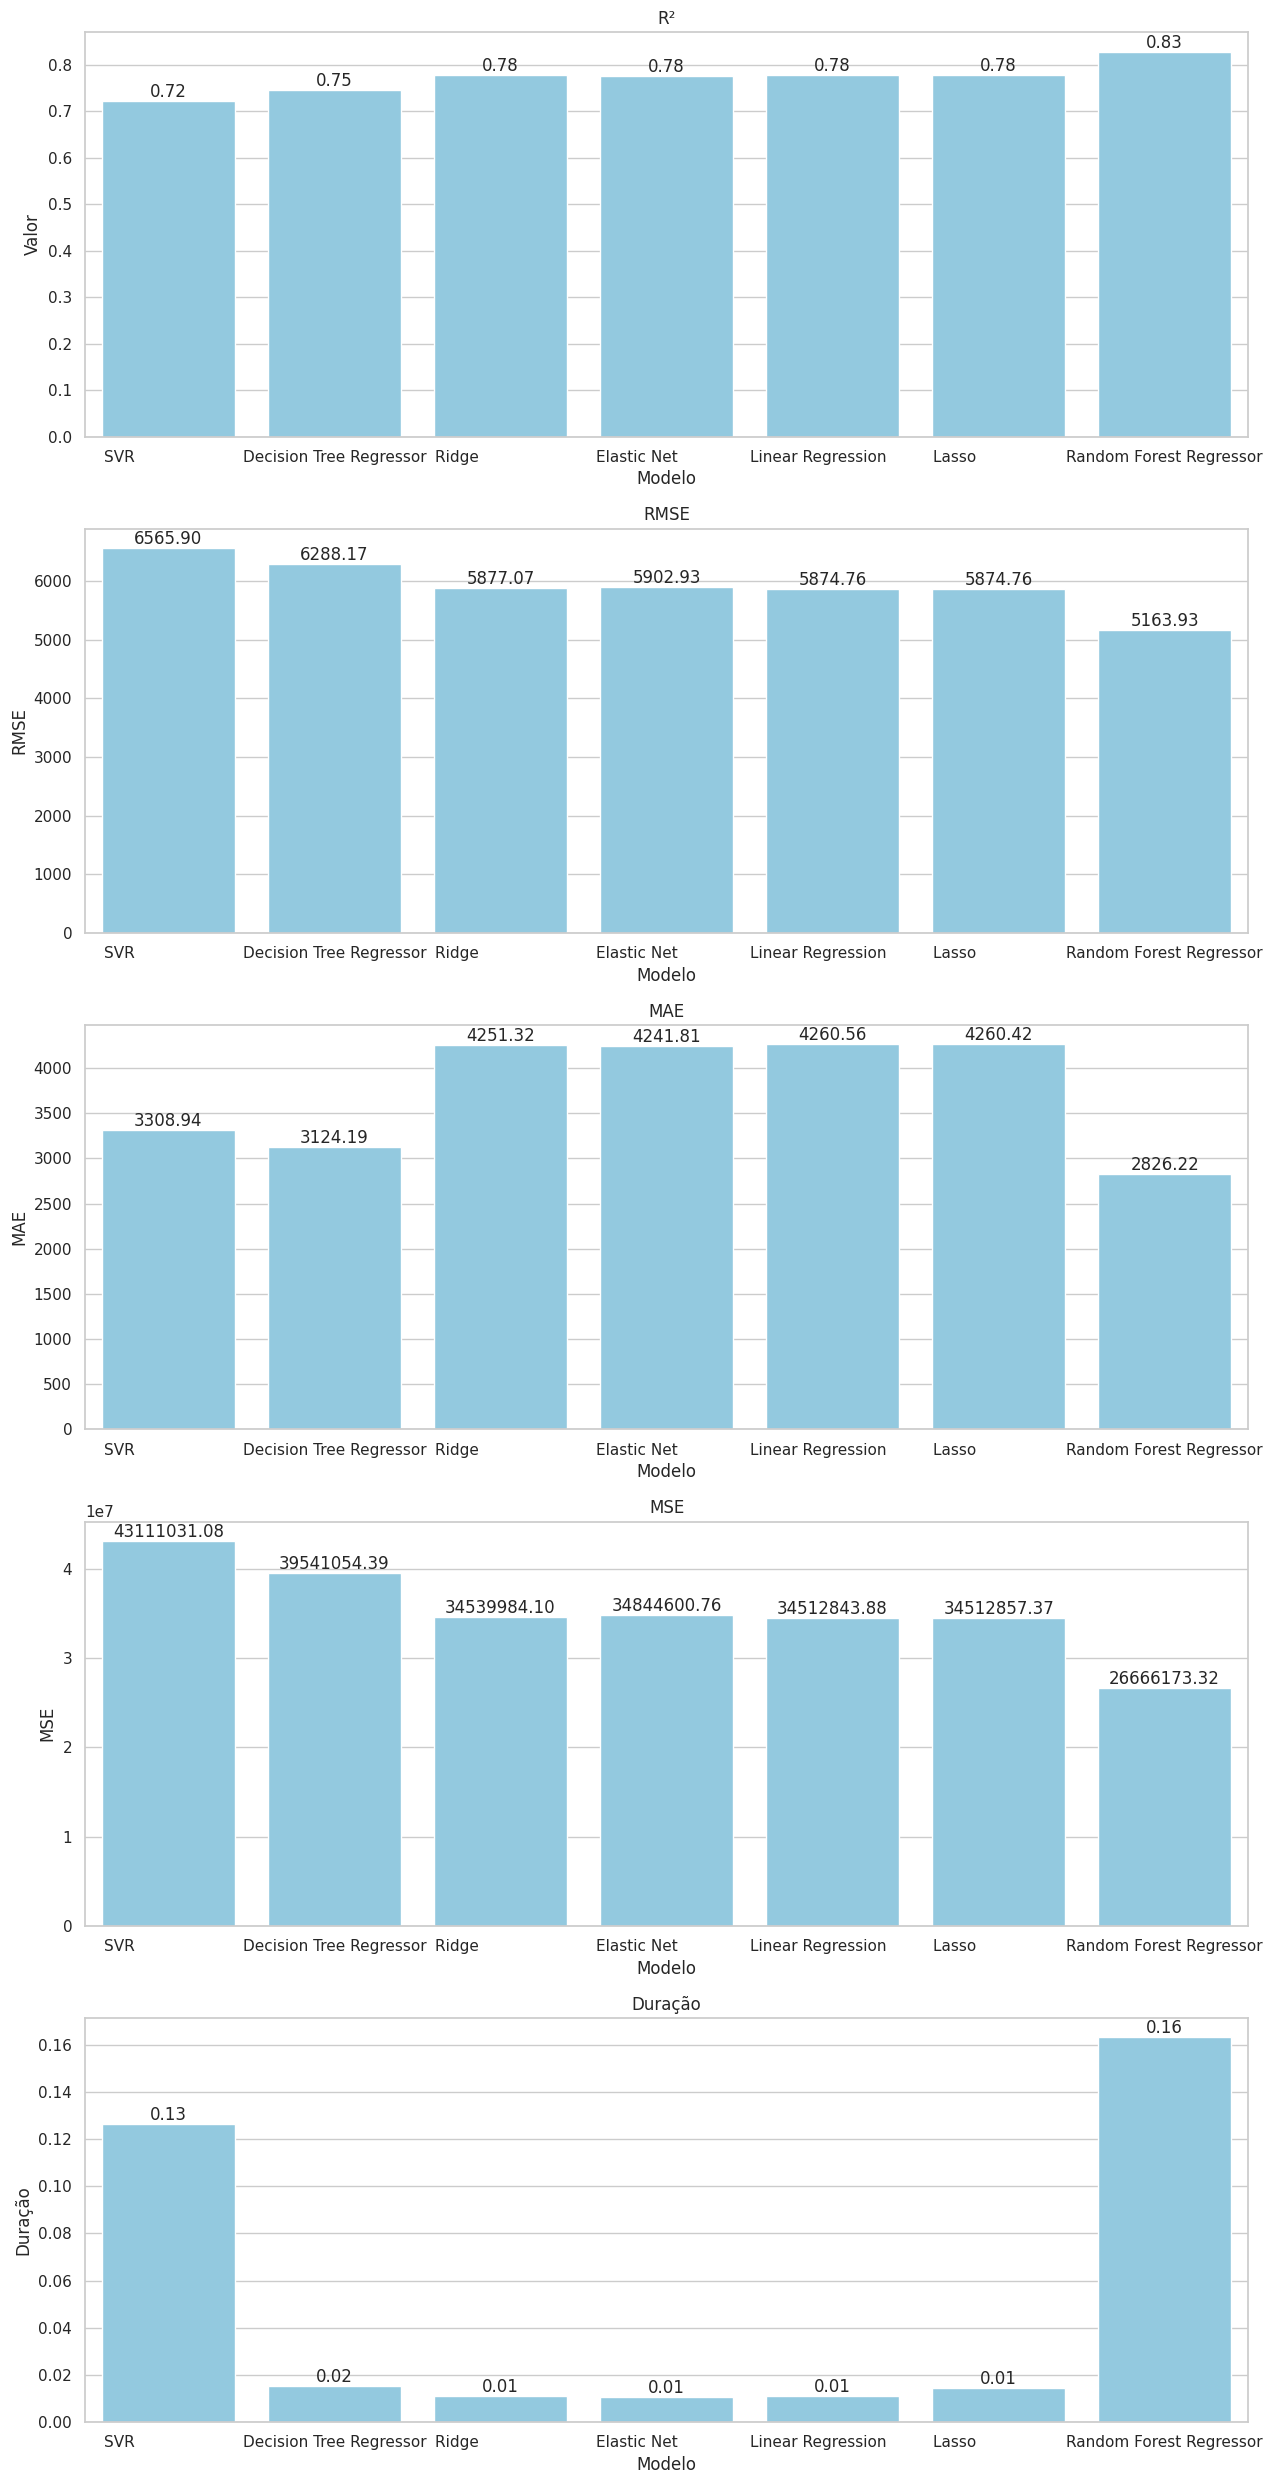

SemScaler


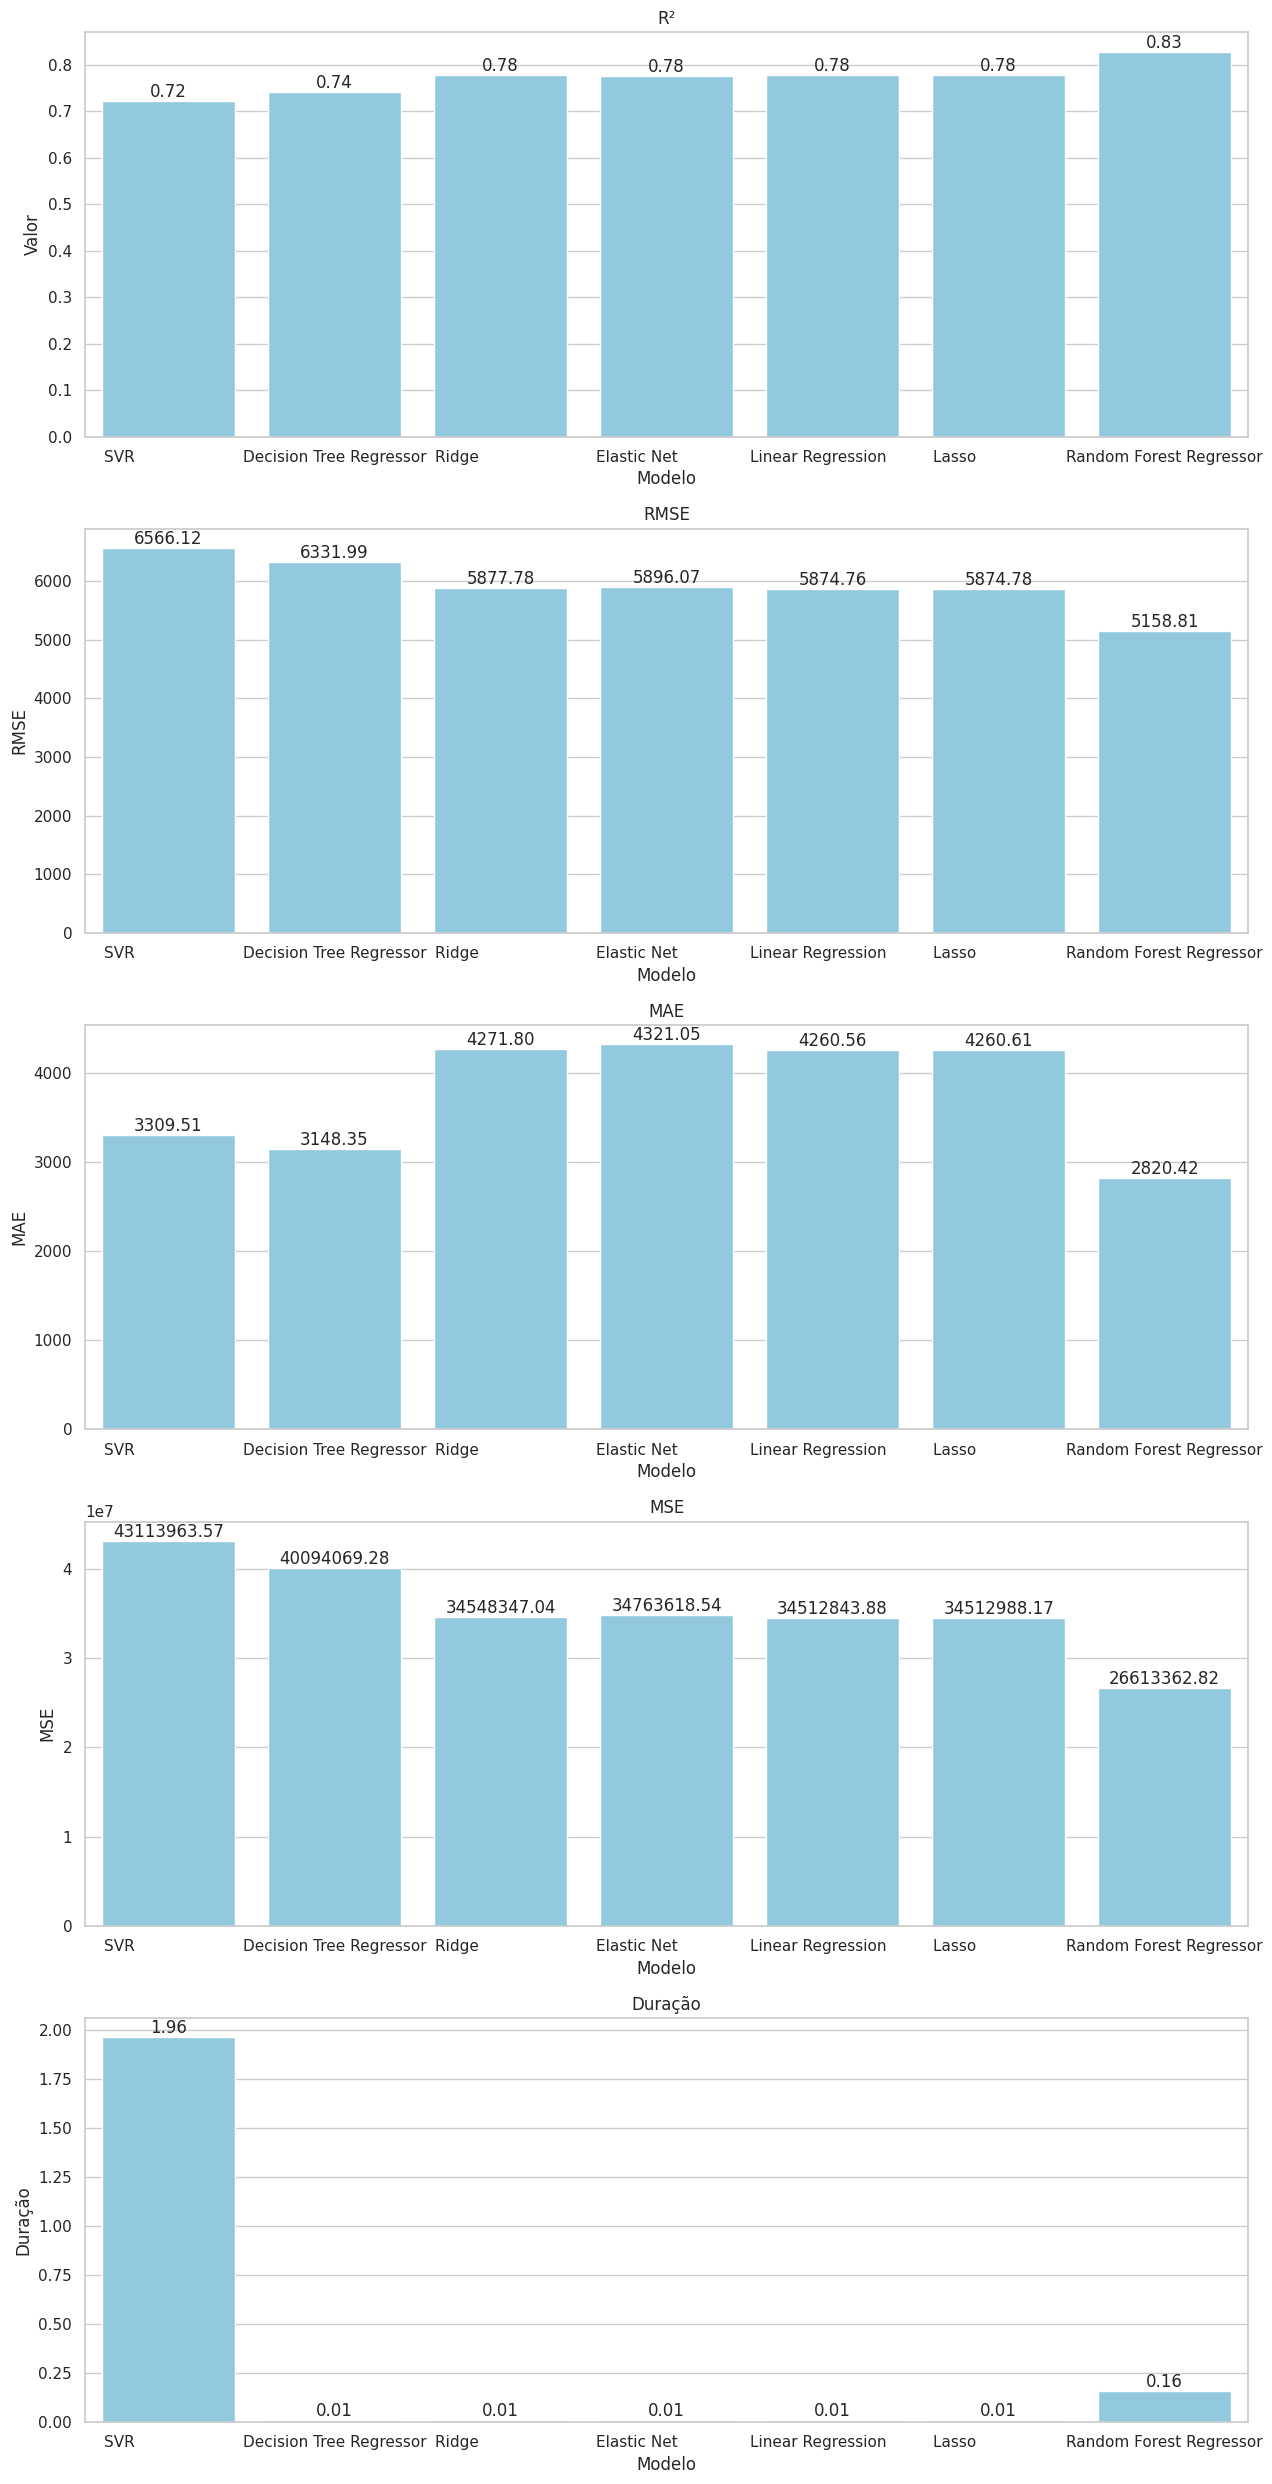

In [ ]:
def generate_graphs(df_results):

  # Listando as métricas para iterar sobre elas
  metrics = ['R²', 'RMSE', 'MAE', 'MSE', 'Duração']

  # Configurando os subplots
  fig, axes = plt.subplots(len(metrics), 1, figsize=(13, 25), sharey=False)

  # Criando um gráfico de barras para cada métrica
  for i, metric in enumerate(metrics):
    # axes[i].bar(df_results['Modelo'], df_results[metric], color="skyblue")
    sns.barplot(data=df_results, x='Modelo', y=metric, ax=axes[i], color="skyblue")
    axes[i].set_title(metric)
    axes[i].set_xlabel('Modelo')


    if i == 0:
        axes[i].set_ylabel('Valor')

    for bar in axes[i].containers[0]:
        axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                      f'{bar.get_height():.2f}', ha='center', va='bottom')

  # Ajusta o layout para evitar sobreposição
  plt.tight_layout()
  plt.show()

for r in df_results:
  r["Scaler"].fillna("SemScaler", inplace=True)
  print(r["Scaler"].unique()[0])
  generate_graphs(r)

Para escolher o melhor modelo de regressão com base nos resultados que você forneceu, podemos considerar as seguintes métricas: MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error) e R² (coeficiente de determinação). Vamos analisar os resultados:

1. Modelos com StandardScaler

**Random Forest Regressor:**

- MAE = 2811.365
- MSE = 26651682.167
- RMSE = 5162.527
- R² = 0.828

2. Modelos com MinMaxScaler

**Random Forest Regressor:**

- MAE = 2826.220
- MSE = 26666173.323
- RMSE = 5163.930
- R² = 0.828

3. Modelos sem Scaler

**Random Forest Regressor:**

- MAE = 2820.420
- MSE = 26613362.823
- RMSE = 5158.814
- R² = 0.829

**Análise**
O Random Forest Regressor se destaca em todas as abordagens (StandardScaler, MinMaxScaler e sem scaler), apresentando o menor MAE, MSE e RMSE, além do maior R² em comparação com os outros modelos.
O modelo de Random Forest apresenta uma performance consistente, sendo o melhor modelo entre os testados.

**Conclusão**
Recomendo escolher o Random Forest Regressor como o modelo de regressão preferido, pois ele obteve o melhor desempenho nas métricas mais relevantes em todos os cenários. Se você está em busca de um modelo robusto, ele é a melhor opção.





In [ ]:
pd.concat(df_results).to_csv('results.csv', index=False)

In [ ]:
df_long

,Modelo,Métrica,Valor
0,SVR,R²,0.717842
1,Decision Tree Regressor,R²,0.749476
2,Ridge,R²,0.777660
3,Elastic Net,R²,0.777502
4,Linear Regression,R²,0.777693
...,...,...,...
100,Ridge,Duração,0.009078
101,Elastic Net,Duração,0.008955
102,Linear Regression,Duração,0.008315
103,Lasso,Duração,0.008236


In [ ]:
df_results.columns

Index(['Scaler', 'Modelo', 'R²', 'RMSE', 'MAE', 'MSE', 'Duração'], dtype='object')

In [ ]:
# Criação de uma função para avaliar os resultados de cada um dos modelos passando o DF e as variáveis de interesse

def linear_regression_analysis(df, variaveis_independentes, variavel_dependente):
    # Seleciona as variáveis independentes e a dependente
    X = df[variaveis_independentes]
    y = df[variavel_dependente]

    # Convertendo as colunas para tipo numérico, forçando a conversão e substituindo erros por NaN
    X = X.apply(pd.to_numeric, errors='coerce').astype(float)
    y = pd.to_numeric(y, errors='coerce').astype(float)

    # Cria e ajusta o modelo de regressão com sklearn
    modelo_sklearn = LinearRegression()
    modelo_sklearn.fit(X, y)

    # Faz previsões
    y_pred = modelo_sklearn.predict(X)

    # Calcula R² e RMSE
    r2 = modelo_sklearn.score(X, y)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Para obter os parâmetros da regressão
    X_sm = sm.add_constant(X)  # Adiciona uma constante para o modelo
    modelo_stats = sm.OLS(y, X_sm).fit()

    # Extrai resultados do modelo statsmodels
    resultados = {
        'R²': r2,
        'RMSE': rmse,
        'Coeficientes': modelo_stats.params,
        'P-valores': modelo_stats.pvalues,
        'Estatística F': modelo_stats.fvalue,
        'P-valor F': modelo_stats.f_pvalue
    }

    return resultados

In [ ]:
df_resultados = []

# Loop através dos cenários
for cenario, variaveis in cenarios.items():
    print(f"Analisando {cenario}...")

    # Separando o dataset
    X_train, X_test, y_train, y_test = split_datasets(df_proc, variaveis, 'charges')

    # Realiza a análise de regressão
    resultados = linear_regression_analysis(pd.concat([X_train, y_train], axis=1), variaveis, 'charges')

    temp = pd.DataFrame(resultados)
    temp['cenario'] = cenario
    df_resultados.append(temp)

Analisando cenario_1...
Analisando cenario_2...
Analisando cenario_3...


In [ ]:
df_resultados[0]

,R²,RMSE,Coeficientes,P-valores,Estatística F,P-valor F,cenario
const,0.111609,11305.991548,-3671.388767,5.132983e-03,33.449047,2.588395e-26,cenario_1
age,0.111609,11305.991548,227.849722,3.934999e-19,33.449047,2.588395e-26,cenario_1
bmi,0.111609,11305.991548,284.849960,7.063029e-07,33.449047,2.588395e-26,cenario_1
children,0.111609,11305.991548,859.485758,3.281209e-03,33.449047,2.588395e-26,cenario_1
sex_female,0.111609,11305.991548,-2374.220908,1.230531e-03,33.449047,2.588395e-26,cenario_1
sex_male,0.111609,11305.991548,-1297.167858,8.355419e-02,33.449047,2.588395e-26,cenario_1


In [ ]:
df_resultados[1]

,R²,RMSE,Coeficientes,P-valores,Estatística F,P-valor F,cenario
const,0.742653,6110.583906,427.847032,5.457565e-01,1025.421627,1.440339e-313,cenario_2
smoker_no,0.742653,6110.583906,-11581.435474,5.463022e-139,1025.421627,1.440339e-313,cenario_2
smoker_yes,0.742653,6110.583906,12009.282506,4.385918e-120,1025.421627,1.440339e-313,cenario_2
bmi,0.742653,6110.583906,311.222379,8.819047e-23,1025.421627,1.440339e-313,cenario_2
age,0.742653,6110.583906,256.722190,2.511763e-70,1025.421627,1.440339e-313,cenario_2


In [ ]:
df_resultados[2]

,R²,RMSE,Coeficientes,P-valores,Estatística F,P-valor F,cenario
const,0.733744,6343.276878,-1918.073290,3.991801e-05,586.43213,1.057848e-302,cenario_3
region_northeast,0.733744,6343.276878,-556.776419,1.203375e-01,586.43213,1.057848e-302,cenario_3
region_northwest,0.733744,6343.276878,-540.751069,1.381510e-01,586.43213,1.057848e-302,cenario_3
region_southeast,0.733744,6343.276878,-208.231436,5.449580e-01,586.43213,1.057848e-302,cenario_3
region_southwest,0.733744,6343.276878,-612.314367,9.109224e-02,586.43213,1.057848e-302,cenario_3
smoker_yes,0.733744,6343.276878,24448.111332,1.065191e-286,586.43213,1.057848e-302,cenario_3
age,0.733744,6343.276878,273.063955,6.612447e-75,586.43213,1.057848e-302,cenario_3


**Cenário 1: Variáveis Demográficas**
- R²: 0.12: Isso indica que apenas cerca de 12% da variação nos custos (charges) pode ser explicada pelas variáveis demográficas escolhidas. É um valor baixo, sugerindo que outras variáveis não consideradas podem ter um impacto significativo.
- RMSE: 11501.90: O erro médio quadrático é relativamente alto, indicando que as previsões do modelo podem estar longe dos valores reais em média.

**Coeficientes:**

- age: Cada aumento de um ano na idade resulta em um aumento médio de aproximadamente 237.16 nas charges.
- bmi: Um aumento de 1 unidade no IMC está associado a um aumento de cerca de 367.36 nas charges.
- children: Cada filho adicional aumenta as charges em cerca de 476.02.
- sex_female e sex_male: O custo é menor para mulheres e homens em comparação com a constante. As diferenças são de aproximadamente 2986.05 e 2139.42, respectivamente.

**P-valores:** A maioria dos p-valores é significativa (menos de 0.05), exceto para a variável children, indicando que idade, IMC e sexo têm um impacto estatisticamente significativo nas charges.

___________________________________________

**Cenário 2: Comportamento de Saúde**
- R²: 0.74: Aqui, cerca de 74% da variação nas charges é explicada pelas variáveis. Esse é um bom ajuste e indica que as variáveis escolhidas são relevantes para explicar os custos.
- RMSE: 6027.03: Um RMSE mais baixo em comparação com o cenário 1 sugere que as previsões são mais precisas.

**Coeficientes:**
- smoker_yes: Fumar está associado a um aumento significativo nas charges (cerca de 11727.75).
- smoker_no: O custo para não fumantes é cerca de 11617.66 menor em comparação com a constante.
- age e bmi também têm um impacto positivo nas charges.

**P-valores:** Todos os p-valores são muito baixos, indicando que todas as variáveis têm um impacto significativo nas charges.


___________________________________________

**Cenário 3: Região e Estilo de Vida**
- R²: 0.73: Assim como o cenário 2, esse cenário também mostra um bom ajuste, com 73% da variação explicada.
- RMSE: 6230.82: O RMSE é um pouco maior que o do cenário 2, mas ainda indica uma boa precisão nas previsões.

**Coeficientes:**

- smoker_yes: Fumantes têm um aumento significativo nos custos, semelhante ao cenário 2.
- age: Cada ano adicional também aumenta os custos em 272.16.
- region: Algumas regiões têm um impacto negativo nas charges, mas apenas a região sul (southwest) é estatisticamente significativa.

**P-valores:** O p-valor para smoker_yes e age são muito baixos, mostrando sua relevância. A maioria das regiões não é estatisticamente significativa, exceto a região southwest.


___________________________________________

### Resumo e Interpretação Geral

- **Cenário 1** revela que as variáveis **demográficas têm um impacto, mas o modelo não explica bem os custos**.
- **Cenário 2** mostra um **forte impacto do comportamento de saúde, especialmente o fator de ser fumante, e fornece um modelo bem ajustado**.
- **Cenário 3** confirma que o **ser fumante e a idade também são relevantes**, mas a **localização geográfica não tem um impacto tão forte**.

A partir dessas análises, pode-se concluir que o **comportamento de saúde (especialmente a variável de ser fumante) é um dos fatores mais críticos para prever os custos de saúde**, mais do que as variáveis demográficas ou regionais.

# EDITADO POR - AURELIO (31/10)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# FALTA ARRUMAR AS VARIAVEIS
axes[0, 0].scatter(y_test, linear_regression_prediction, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_title('Linear Regression')
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predictions')

axes[0, 1].scatter(y_test, knn_prediction, alpha=0.6, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 1].set_title('KNN')
axes[0, 1].set_xlabel('Real')

axes[1, 0].scatter(y_test, decisiontree_prediction, alpha=0.6, color='purple')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 0].set_title('Decision Tree')
axes[1, 0].set_xlabel('Real')
axes[1, 0].set_ylabel('Predictions')

axes[1, 1].scatter(y_test, randomforest_prediction, alpha=0.6, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 1].set_title('Random Forest')
axes[1, 1].set_xlabel('Real')

plt.suptitle('Real vs. Predictions')
plt.show()

In [ ]:
models = ['Linear Regression', 'KNN', 'Decision Tree', 'Random Forest']
r2_scores = [linear_predict_time, knn_predict_time, decision_tree_predict_time, random_forest_predict_time]

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Performance Model Evaluation (ms)')
plt.xlabel('Models')
plt.ylabel('ms')
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()